In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from random import randint
from tqdm import tqdm
from copy import deepcopy

sys.path.append('..')
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/gaussian_mixture')
from dset import get_dataloaders
from model import init_specific_model
from losses import get_loss_f
from training import Trainer
from viz import plot_2d_latent_samples, plot_traversals, save_fig
from sim_gaussian_mixture import define_dataloaders

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder

sys.path.append('../../lib/disentangling-vae')
import main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
args = main.parse_arguments()
args.model_type = "Lin"
args.rec_dist = "gaussian"
args.reg_anneal = 0
args.beta = 0.1
args.lamPT = 0.0
args.lamNN = 0.0
args.lamH = 0
args.lamSP = 0.0
args.latent_dim = 4    
args.num_epochs = 100

In [57]:
class p:
    '''Parameters for Gaussian mixture simulation
    '''
    # parameters for generating data
    seed = 13
    train_n_samples_per_cluster = 5000
    test_n_samples_per_cluster = 1000
    latent_means = [[0.0, 0.0], [15.0, 15.0], [100.0, 100.0]]
    latent_vars = [[4, 1], [4, 1], [4, 1]]
    noise_dim = 8
    noise_var = 0.01
    
    # parameters for model architecture
    model_type = "Lin"
    orig_dim = 10
    latent_dim = 4    
    hidden_dim = 12
    
    # parameters for training
    train_batch_size = 64
    test_batch_size = 100
    lr = 1*1e-4
    rec_dist = "gaussian"
    reg_anneal = 0
    num_epochs = 100
    
    # parameters for loss
    beta = 0.0
    lamPT = 0.0
    lamNN = 0.0
    lamH = 0.0
    lamSP = 0.0    
    
    # parameters for exp
    warm_start = None # which parameter to warm start with respect to
    seq_init = 1      # value of warm_start parameter to start with respect to
    
    # SAVE MODEL
    out_dir = "/home/ubuntu/local-vae/notebooks/ex_gaussian_mixture/results" # wooseok's setup
#     out_dir = '/scratch/users/vision/chandan/local-vae' # chandan's setup
    dirname = "vary"
    pid = ''.join(["%s" % randint(0, 9) for num in range(0, 10)])

    def _str(self):
        vals = vars(p)
        return 'beta=' + str(vals['beta']) + '_lamPT=' + str(vals['lamPT']) + '_lamNN=' + str(vals['lamNN']) + '_lamSP=' + str(vals['lamSP']) \
                + '_seed=' + str(vals['seed']) + '_pid=' + vals['pid']
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(self).items()
                 if not attr.startswith('_')}
    

In [58]:
for arg in vars(args):
    setattr(p, arg, getattr(args, arg))
    
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)   

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
(train_loader, test_loader) = define_dataloaders(p)

# prepare model
model = init_specific_model(model_type=p.model_type, 
                            img_size=p.orig_dim,
                            latent_dim=p.latent_dim,
                            hidden_dim=p.hidden_dim).to(device)

# train
optimizer = torch.optim.Adam(model.parameters(), lr=p.lr)
loss_f = get_loss_f(decoder=model.decoder, **vars(p))
trainer = Trainer(model, optimizer, loss_f, device=device)


In [59]:
trainer(train_loader, test_loader, epochs=p.num_epochs)

====> Epoch: 0 Average train loss: 3428.9329 (Test set loss: 53.7244)
====> Epoch: 1 Average train loss: 39.6511 (Test set loss: 30.0848)
====> Epoch: 2 Average train loss: 26.4020 (Test set loss: 22.1380)
====> Epoch: 3 Average train loss: 19.9482 (Test set loss: 16.9951)
====> Epoch: 4 Average train loss: 15.8179 (Test set loss: 13.7179)
====> Epoch: 5 Average train loss: 13.0672 (Test set loss: 11.4548)
====> Epoch: 6 Average train loss: 11.1298 (Test set loss: 9.8443)
====> Epoch: 7 Average train loss: 9.7696 (Test set loss: 8.7636)
====> Epoch: 8 Average train loss: 8.7675 (Test set loss: 7.8784)
====> Epoch: 9 Average train loss: 8.0144 (Test set loss: 7.1950)
====> Epoch: 10 Average train loss: 7.4121 (Test set loss: 6.6973)
====> Epoch: 11 Average train loss: 6.9597 (Test set loss: 6.3246)
====> Epoch: 12 Average train loss: 6.5303 (Test set loss: 5.9121)
====> Epoch: 13 Average train loss: 6.1392 (Test set loss: 6.0718)
====> Epoch: 14 Average train loss: 5.9657 (Test set loss

## Visualize the directions of the model which disentangles the best

Text(0.5, 1.0, 'Plot of test latent samples')

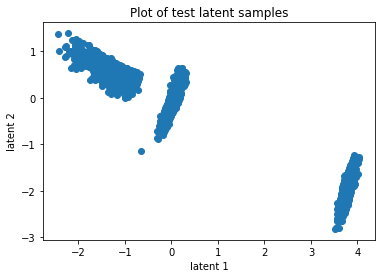

In [60]:
# EVALUATE TEST DATA
data = test_loader.dataset.data.to(device)
recon_data, latent_dist, latent_sample = model(data)
plot_2d_latent_samples(latent_sample)
plt.xlabel('latent 1')
plt.ylabel('latent 2')
plt.title("Plot of test latent samples")

Text(0.5, 1.0, 'Plot of traversals')

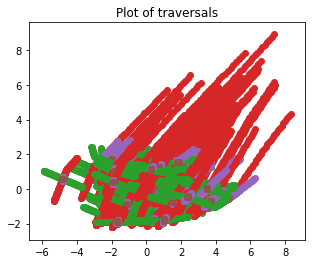

In [61]:
plot_traversals(model, data, lb=0, ub=1000, num=100, max_traversal=.5)
plt.title("Plot of traversals")

Text(0.5, 1.0, 'Plot of traversals')

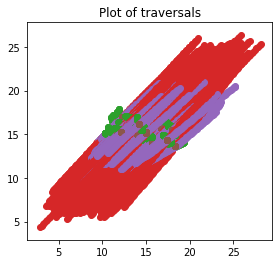

In [62]:
plot_traversals(model, data, lb=1000, ub=2000, num=100, max_traversal=.5)
plt.title("Plot of traversals")

Text(0, 0.5, 'data dimension 2')

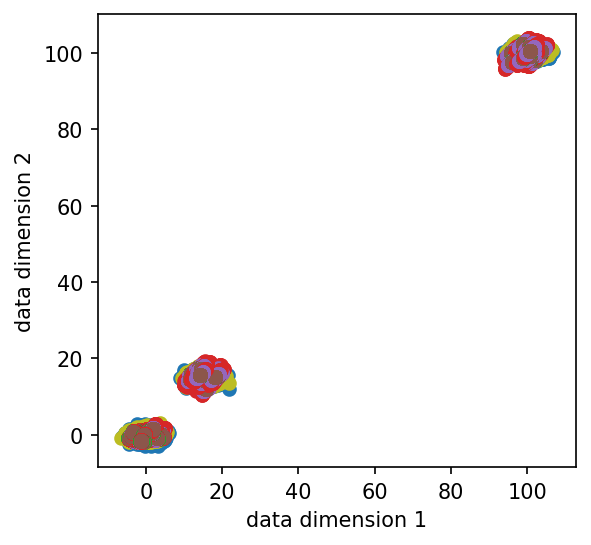

In [63]:
plt.figure(dpi=150)
plot_traversals(model, data, lb=0, ub=3000, num=100,
                draw_data=True, draw_recon=True, max_traversal=0.1)
plt.xlabel('data dimension 1')
plt.ylabel('data dimension 2')